In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D


# Set aesthetics
sns.set(style="whitegrid")


In [27]:
#Load and prepare data
df = pd.read_csv("HR_data.csv", index_col=0)
df = df.dropna(axis=1, how="any") # some emotion columns are removed
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

# convert categorical features, one-hot encoding
df = pd.get_dummies(df, columns=["Round"], drop_first=True)
df = pd.get_dummies(df, columns=["Phase"], drop_first=True)
# df = pd.get_dummies(df, columns=["Cohort"], drop_first=True)


#Extract numeric features and target
target_cols = ["Cohort"]

X_cols = list(set(df.columns) - set(target_cols))
y = df[target_cols]

# normalize the continuous features between 0 and 1
for col in X_cols:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

X = df[X_cols]

# print(X.columns)

# Data perparation
X_train = np.array(X)
y_train = np.array(y)

In [28]:
# Gap statistic prep
Nsim = 20
K_range = range(2, 11)
n_clusters = len(K_range)
W = np.zeros(n_clusters)
Wu = np.zeros((n_clusters, Nsim))

N, p = X_train.shape
minX = np.min(X_train, axis=0)
maxX = np.max(X_train, axis=0)

for i, k in enumerate(K_range):
    # === Actual data clustering ===
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    for cluster in range(k):
        cluster_indices = np.where(labels == cluster)[0]
        dists = np.sum((X_train[cluster_indices] - centers[cluster])**2, axis=1)
        W[i] += np.sum(dists)

    # === Simulated data clustering ===
    for j in range(Nsim):
        X_uniform =  np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        kmeans_u = KMeans(n_clusters=k, random_state=42).fit(X_uniform)
        labels_u = kmeans_u.labels_
        centers_u = kmeans_u.cluster_centers_

        for cluster in range(k):
            cluster_indices = np.where(labels_u == cluster)[0]
            dists = np.sum((X_uniform[cluster_indices] - centers_u[cluster])**2, axis=1)
            Wu[i, j] += np.sum(dists)

# === Gap Statistic ===
log_W = np.log(W)
log_Wu = np.log(Wu)
Elog_Wu = np.mean(log_Wu, axis=1)
sk = np.std(log_Wu, axis=1) * np.sqrt(1 + 1 / Nsim)
gap = Elog_Wu - log_W

# === Find gap criterion ===
gap_criterion = np.zeros(len(K_range) - 1)
for i in range(len(K_range) - 1):
    gap_criterion[i] = gap[i] - (gap[i + 1] - sk[i + 1])


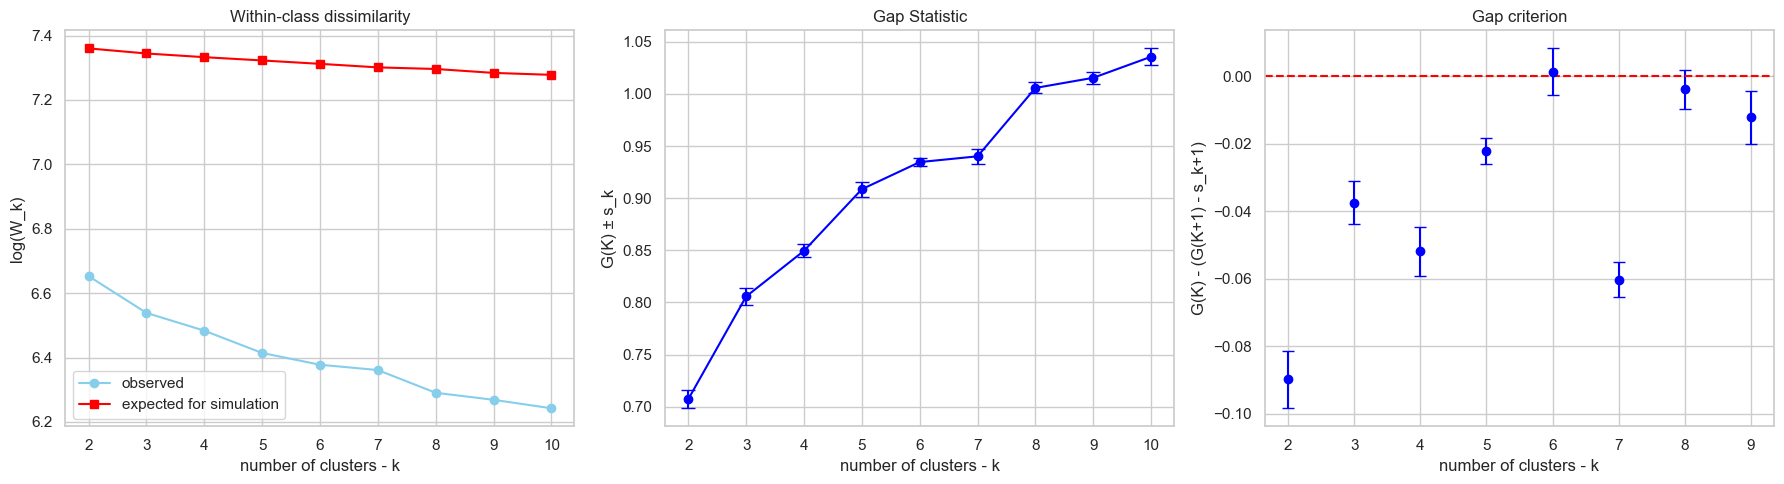

In [29]:
# --- Plotting ---
plt.figure(figsize=(18, 5))

# log(W_k) vs k
plt.subplot(1, 3, 1)
plt.plot(K_range, log_W, marker='o', label='observed', color='skyblue')
plt.plot(K_range, Elog_Wu, marker='s', label='expected for simulation', color='red')
plt.xlabel('number of clusters - k')
plt.ylabel('log(W_k)')
plt.title('Within-class dissimilarity')
plt.legend()

# Gap curve with error bars
plt.subplot(1, 3, 2)
plt.errorbar(K_range, gap, yerr=sk, marker='o', color='blue', capsize=5)
plt.xlabel('number of clusters - k')
plt.ylabel('G(K) ± s_k')
plt.title('Gap Statistic')

# Gap criterion plot
plt.subplot(1, 3, 3)
plt.errorbar(K_range[:-1], gap_criterion, yerr=sk[1:], fmt='o', color='blue', capsize=4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('number of clusters - k')
plt.ylabel('G(K) - (G(K+1) - s_k+1)')
plt.title('Gap criterion')

plt.tight_layout()
plt.show()


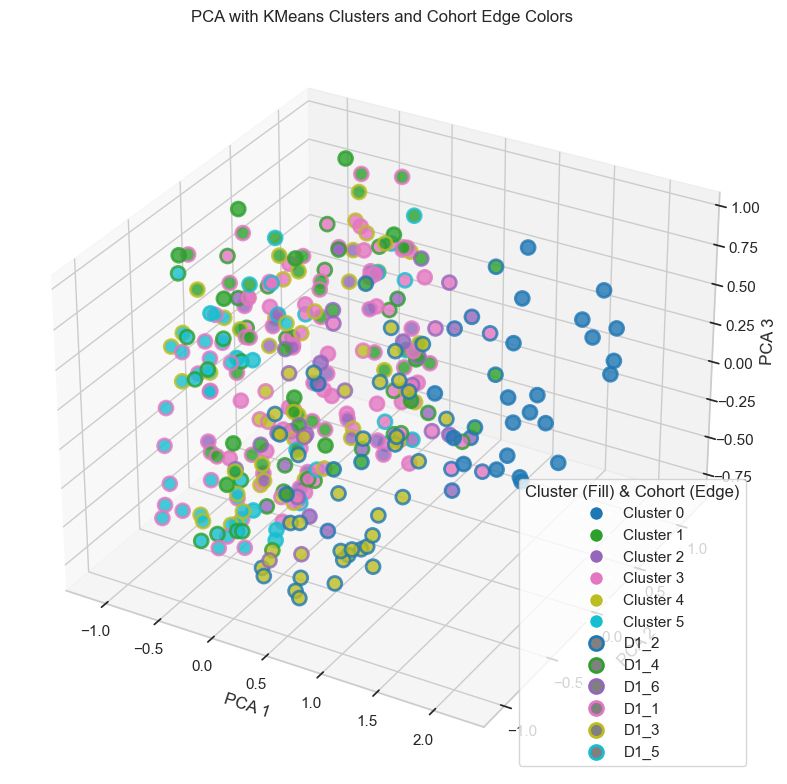

In [ ]:
# KMeans clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_train)

# PCA transformation
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)
df['PCA1'], df['PCA2'], df['PCA3'] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

# Map Cohort to edge colors
unique_cohorts = df['Cohort'].unique()
cohort_colors = dict(zip(unique_cohorts, plt.cm.tab10.colors[:len(unique_cohorts)]))
cmap = plt.cm.get_cmap('tab10', max(n_clusters, len(unique_cohorts)))

# Map Cluster to fill colors and Cohort to edge colors using the same colormap
cluster_colors = df['Cluster'].map(lambda x: cmap(x))
cohort_ids = {cohort: idx for idx, cohort in enumerate(unique_cohorts)}
edge_colors = df['Cohort'].map(lambda x: cmap(cohort_ids[x]))

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['PCA1'],
    df['PCA2'],
    df['PCA3'],
    c=cluster_colors,   # Fill color: cluster
    s=100,
    alpha=0.8,
    edgecolors=edge_colors,  # Edge color: cohort
    linewidths=2
)

ax.set_title('PCA with KMeans Clusters and Cohort Edge Colors')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')


cluster_legend_patches = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=cmap(i), markersize=10)
    for i in range(n_clusters)
]
cohort_legend_patches = [
    Line2D([0], [0], marker='o', color='w', label=cohort,
           markerfacecolor='gray', markeredgecolor=cmap(idx), markersize=10, markeredgewidth=2)
    for cohort, idx in cohort_ids.items()
]

ax.legend(handles=cluster_legend_patches + cohort_legend_patches,
          title="Cluster (Fill) & Cohort (Edge)",
          loc='best')

plt.tight_layout()
plt.show()
